#


# Evaluate fine-tuned VGG16 on noisy test set - IF CONTINUING, NEED TO CHANGE TO THE VERSION WITH CLASSIFICATION REPORT


This is to evaluate the robustness of the fine-tuned models to noise. Without this, we only know how these fine-tuned models perform on the existing clean test set, but we don't know how it performs on noisy speech samples


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
test_csv = '../../../data/melspectrogram_test_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

fine_tuned_weights = 'best_vgg16_normalized.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the testing/evaluation function


In [7]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    all_preds = []
    all_labels = []

    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # Save predictions and labels for later use
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy, all_preds, all_labels

Define a class to add Gaussian noise to the test mel spectrograms


In [8]:
from data_augmentation.AddGaussianNoise import AddGaussianNoise

Define the model


In [9]:
# We don't load ImageNet weights here since we'll load our fine-tuned weights
model = models.vgg16(pretrained=False)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Add Gaussian noise to the test set


In [10]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to model input size
    transforms.ToTensor(),
    AddGaussianNoise(noise_factor_range=(0.2, 0.2)  # Fixed noise factor
                     ),  # Use a fixed noise level
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Execute the evaluation


In [11]:
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_classes = 9  # Adjust according to your dataset

num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)

# Load the fine-tuned weights (change the filename as needed)
model.load_state_dict(torch.load(fine_tuned_weights, map_location=device))
model.to(device)

# Evaluate the model on the noisy test set
test_loss, test_accuracy, all_preds, all_labels = test(
    model, testloader, criterion, device)
print(f"Noisy Test Loss: {test_loss:.4f}")
print(f"Noisy Test Accuracy: {test_accuracy:.2f}%")

C:\Users\profi\AppData\Local\Temp\ipykernel_24084\3321001132.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)
C:

Noisy Test Loss: 2.1626
Noisy Test Accuracy: 26.95%


Plot confusion matrix


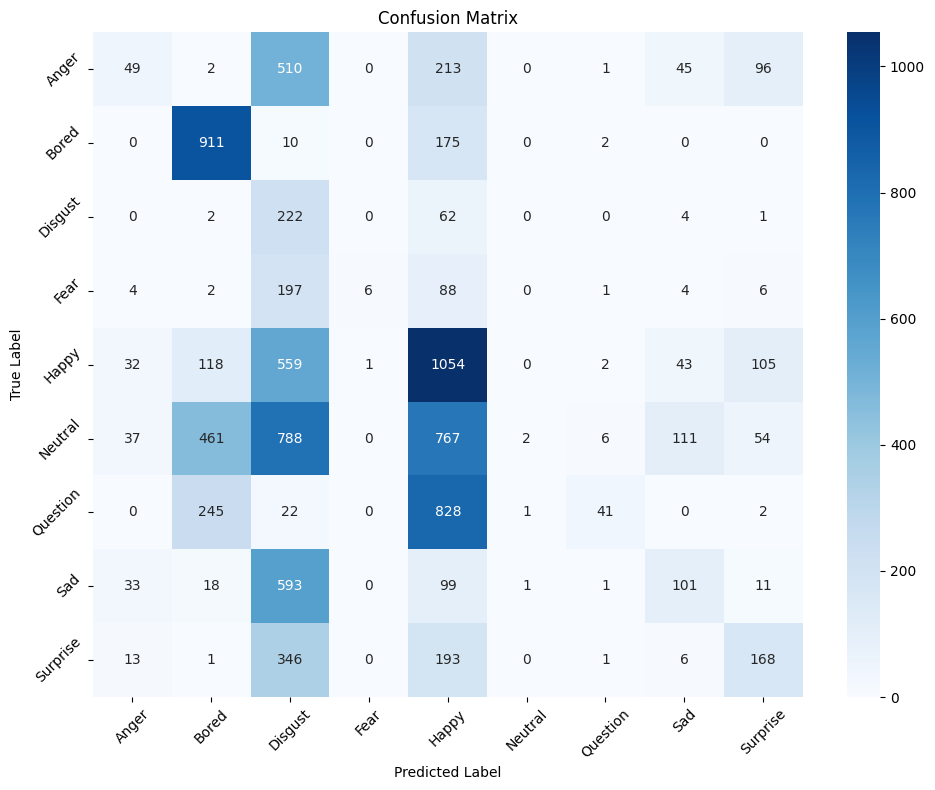

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formattinga
                cmap='Blues',  # Color scheme
                xticklabels=testset.label_map.keys(),
                yticklabels=testset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)